In [1]:
import logging
import os
import random
from collections import Counter
from importlib import reload


import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import pollock
from pollock.models.model import PollockDataset, PollockModel, load_from_directory
import pollock.models.analysis as pollock_analysis

/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
# pollock.models.model.set_training_devices(['/device:XLA_GPU:0'])

In [ ]:
# from importlib import reload
# reload(pollock)
# reload(pollock.models.model)

In [5]:
from tensorflow.python.client import device_lib
import tensorflow as tf
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13525296768382337487,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9550179822592911233
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17633174866615562201
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16251391668736141291
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13578491073211611333
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17494869130234769265
 physical_device_desc: "device: XLA_GPU device

In [7]:
# tf.config.list_physical_devices('XLA_GPU')

In [8]:
# tf.keras.backend.clear_session()
# tf.config.optimizer.set_jit(True)

In [9]:
# mirrored_strategy = tf.distribute.MirroredStrategy(
#     devices=["/device:XLA_GPU:0"])

## load in expression table and labels

In [6]:
expression_fp = '/home/estorrs/data/single_cell_classification/Intra-dataset/Zheng 68K/Filtered_68K_PBMC_data.csv'
label_fp = '/home/estorrs/data/single_cell_classification/Intra-dataset/Zheng 68K/Labels.csv'


In [10]:
expression_fp = '/Volumes/timmy/ding/scRNAseq_classification_datasets/scRNAseq_benchmark/Intra-dataset/Zheng 68K/Filtered_68K_PBMC_data.csv'
label_fp = '/Volumes/timmy/ding/scRNAseq_classification_datasets/scRNAseq_benchmark/Intra-dataset/Zheng 68K/Labels.csv'

In [7]:
%%time
expression_df = pd.read_csv(
    expression_fp,
    sep=',')
expression_df

CPU times: user 6min 14s, sys: 16.7 s, total: 6min 30s
Wall time: 6min 28s


,Unnamed: 0,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
0,AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65938,TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65939,TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65940,TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,TTTGCATGCTGCAA-8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
expression_df = expression_df.set_index('Unnamed: 0')
expression_df

,AL627309.1,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,RP11-54O7.1,SAMD11,...,AC145212.1,MGC39584,AC011043.1,ZNF84.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2.1,SRSF10.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
AAACATACCCCTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACCGGAGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTAACCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACATACTCTTCA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGACACCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGAGCCTA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGCATGCTAGCA-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
label_df = pd.read_csv(
    label_fp,
    sep=','
    )
label_df

,x
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
65938,CD8+/CD45RA+ Naive Cytotoxic
65939,CD8+ Cytotoxic T
65940,CD8+/CD45RA+ Naive Cytotoxic
65941,CD8+ Cytotoxic T


In [125]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

Transforming to str index.


AnnData object with n_obs × n_vars = 65943 × 20387 
    obs: 'x'

In [126]:
adata.X.nbytes

5377519764

In [127]:
Counter(adata.obs['x']).most_common()

[('CD8+ Cytotoxic T', 20307),
 ('CD8+/CD45RA+ Naive Cytotoxic', 16361),
 ('CD56+ NK', 8522),
 ('CD4+/CD25 T Reg', 6116),
 ('CD19+ B', 5579),
 ('CD4+/CD45RO+ Memory', 3031),
 ('Dendritic', 1946),
 ('CD14+ Monocyte', 1944),
 ('CD4+/CD45RA+/CD25- Naive T', 1857),
 ('CD34+', 188),
 ('CD4+ T Helper2', 92)]

In [59]:
## filter smartly
cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs['x']):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > 100:
        return random.sample(ls, 100)
    return ls

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
adata = adata[idxs]

In [60]:
# def make_safe_filename(s):
#     def safe_char(c):
#         if c.isalnum():
#             return c
#         else:
#             return "_"
#     return "".join(safe_char(c) for c in s).rstrip("_")

# adata.obs['x'] = [make_safe_filename(x) for x in adata.obs['x']]
# adata

In [61]:
Counter(adata.obs['x']).most_common()

[('CD8+ Cytotoxic T', 100),
 ('CD8+/CD45RA+ Naive Cytotoxic', 100),
 ('CD4+/CD45RO+ Memory', 100),
 ('CD19+ B', 100),
 ('CD4+/CD25 T Reg', 100),
 ('CD56+ NK', 100),
 ('CD4+/CD45RA+/CD25- Naive T', 100),
 ('CD34+', 100),
 ('Dendritic', 100),
 ('CD14+ Monocyte', 100),
 ('CD4+ T Helper2', 92)]

In [17]:
adata.var

""
AL627309.1
AP006222.2
RP11-206L10.3
RP11-206L10.2
RP11-206L10.9
...
AC011841.1
AL354822.1
KIR2DL2
PNRC2.1


In [237]:
# sc.tl.rank_genes_groups(adata, 'x', n_genes=100)

In [238]:
# sc.pl.rank_genes_groups(adata)

In [239]:
# sc.pp.scale(adata)

In [240]:
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata)

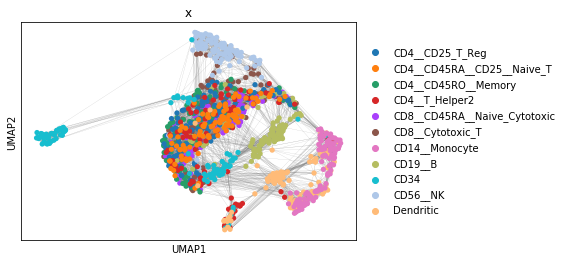

In [71]:
# sc.tl.umap(adata)
# sc.pl.umap(adata, color='x', edges=True)

In [241]:
# sc.pp.neighbors(adata, n_neighbors=15)

In [242]:
# g_template, c_template = pollock.models.model.create_block_image_template(
#         adata, key='x', block_shape=(4, 4), size=(128, 128), nn_threshold=.05)
# g_template, c_template

In [243]:
# sorted(set(c_template.flatten()))

In [244]:
# plt.imshow(c_template=='')

## train pollock model

In [131]:
%%time

pollock_dataset = pollock.models.model.PollockDataset(adata, cell_type_key='x', dataset_type='training',
                                image_root_dir='/home/estorrs/pollock/models/scratch/zheng_68k_unfiltered_training',
                                n_per_cell_type=10000, max_val_per_cell_type=1000)

2020-02-12 18:17:56,996 creating image templates
Trying to set attribute `.uns` of view, copying.
2020-02-12 18:18:12,922 setting up close groupings
2020-02-12 18:18:12,924 calculating nearest neighbors
/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/pollock/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
2020-02-12 18:18:22,147 calculating connectivities
2020-02-12 18:19:28,793 calculating differential genes
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


CPU times: user 45min 37s, sys: 46.8 s, total: 46min 24s
Wall time: 40min 17s


In [132]:
x,y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 11]))

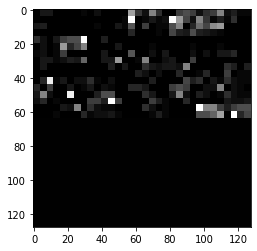

In [133]:
cell_id = adata.obs.index[0]
img = pollock_dataset.get_cell_image(cell_id)

In [134]:
pollock_dataset.cell_types, sorted(set(pollock_dataset.cell_type_template.flatten()))

(['CD14+ Monocyte',
  'CD19+ B',
  'CD34+',
  'CD4+ T Helper2',
  'CD4+/CD25 T Reg',
  'CD4+/CD45RA+/CD25- Naive T',
  'CD4+/CD45RO+ Memory',
  'CD56+ NK',
  'CD8+ Cytotoxic T',
  'CD8+/CD45RA+ Naive Cytotoxic',
  'Dendritic'],
 ['',
  'CD14+ Monocyte',
  'CD14+ Monocyte_diff_Dendritic',
  'CD19+ B',
  'CD19+ B_diff_CD4+ T Helper2',
  'CD19+ B_diff_CD4+/CD45RA+/CD25- Naive T',
  'CD19+ B_diff_CD8+/CD45RA+ Naive Cytotoxic',
  'CD34+',
  'CD4+ T Helper2',
  'CD4+ T Helper2_diff_CD4+/CD25 T Reg',
  'CD4+ T Helper2_diff_CD4+/CD45RA+/CD25- Naive T',
  'CD4+ T Helper2_diff_CD4+/CD45RO+ Memory',
  'CD4+ T Helper2_diff_CD8+ Cytotoxic T',
  'CD4+ T Helper2_diff_CD8+/CD45RA+ Naive Cytotoxic',
  'CD4+ T Helper2_diff_Dendritic',
  'CD4+/CD25 T Reg',
  'CD4+/CD25 T Reg_diff_CD4+/CD45RA+/CD25- Naive T',
  'CD4+/CD25 T Reg_diff_CD4+/CD45RO+ Memory',
  'CD4+/CD25 T Reg_diff_CD8+ Cytotoxic T',
  'CD4+/CD25 T Reg_diff_CD8+/CD45RA+ Naive Cytotoxic',
  'CD4+/CD45RA+/CD25- Naive T',
  'CD4+/CD45RA+/CD25- N

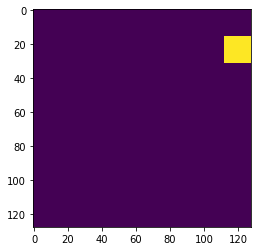

In [136]:
plt.imshow(pollock_dataset.cell_type_template=='CD4+ T Helper2_diff_CD4+/CD25 T Reg')

In [145]:
model = PollockModel(pollock_dataset.cell_types, model=None)

In [146]:
model.model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)            

In [147]:
# with tf.device('/device:XLA_GPU:0'):

model.fit(pollock_dataset, epochs=2)

Train for 1719 steps, validate for 107 steps
Epoch 1/2
1719/1719 [==============================] - 224s 130ms/step - loss: 0.7402 - accuracy: 0.7119 - val_loss: 0.7683 - val_accuracy: 0.7053
Epoch 2/2
1719/1719 [==============================] - 224s 130ms/step - loss: 0.5038 - accuracy: 0.8015 - val_loss: 0.7328 - val_accuracy: 0.7259


In [148]:
pollock_dataset.val_length

6815

In [149]:
# list(pollock_dataset.val_ds.unbatch())

In [150]:
X_val, y_val = None, None
for X, y in pollock_dataset.val_ds.take((pollock_dataset.val_length // 64) + 1):
    if X_val is None:
        X_val = X
        y_val = y
    else:
        X_val = np.concatenate((X_val, X), axis=0)
        y_val = np.concatenate((y_val, y), axis=0)
        
y_val = np.asarray([model.class_names[x] for x in np.argmax(y_val, axis=1).flatten()])
X_val, y_val = X_val[:pollock_dataset.val_length], y_val[:pollock_dataset.val_length]
        
X_val.shape, y_val.shape

((6815, 128, 128, 3), (6815,))

In [151]:
model.class_names

['CD14+ Monocyte',
 'CD19+ B',
 'CD34+',
 'CD4+ T Helper2',
 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T',
 'CD4+/CD45RO+ Memory',
 'CD56+ NK',
 'CD8+ Cytotoxic T',
 'CD8+/CD45RA+ Naive Cytotoxic',
 'Dendritic']

In [152]:
model.save(pollock_dataset, '/home/estorrs/pollock/models/zheng_68k_unfiltered',
          X_val=X_val, y_val=y_val)

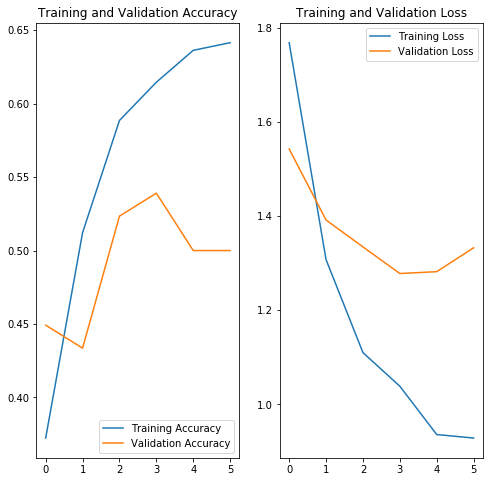

In [116]:
pollock_analysis.show_history(model.history)

In [29]:
%%time
# prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/abm_3class',
#         image_root_dir = '/home/estorrs/pollock/models/scratch/test_amb_prediction')

prediction_dataset, model = load_from_directory(adata, '/home/estorrs/pollock/models/zheng_68k_unfiltered',
        image_root_dir = '/home/estorrs/pollock/models/scratch/test_zheng_68k_unfiltered_prediction')

2020-02-12 14:52:24,813 writing images
2020-02-12 14:52:24,814 0 cell images written
2020-02-12 14:52:59,291 1000 cell images written
2020-02-12 14:53:33,920 2000 cell images written
2020-02-12 14:54:08,504 3000 cell images written
2020-02-12 14:54:42,867 4000 cell images written
2020-02-12 14:55:17,265 5000 cell images written
2020-02-12 14:55:51,748 6000 cell images written
2020-02-12 14:56:26,115 7000 cell images written
2020-02-12 14:57:00,600 8000 cell images written
2020-02-12 14:57:35,063 9000 cell images written
2020-02-12 14:57:44,754 done writing images


Found 9280 images belonging to 1 classes.
CPU times: user 5min 20s, sys: 1.6 s, total: 5min 21s
Wall time: 5min 20s


In [154]:
# probs = model.predict(prediction_dataset)
probs = model.predict(X_val)

probs.shape

(6815, 11)

In [155]:
# [np.max(x) for x in probs]

In [176]:
predictions = np.argmax(probs, axis=1).flatten()
max_prob = np.asarray([np.max(x) for x in probs])
predicted_labels = [prediction_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

(6815, array([ 5,  6,  8,  1, 10]))

In [177]:
# cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
# groundtruth = [cell_type_to_index[cell_type]
#                for cell_type in adata[prediction_dataset.cell_ids, :].obs['x']]

cell_type_to_index = {v:k for k, v in enumerate(pollock_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in y_val]
len(groundtruth), groundtruth[:5]

(6815, [5, 6, 8, 1, 10])

In [178]:
predictions, groundtruth = zip(*[(p, g) for p, g, prob in zip(predictions, groundtruth, max_prob)
                                if prob > .9])
len(predictions), len(groundtruth)

(2678, 2678)

In [179]:
from sklearn.metrics import classification_report
report = classification_report(groundtruth, predictions, target_names=pollock_dataset.cell_types,
                               output_dict=True)
report

{'CD14+ Monocyte': {'precision': 0.848,
  'recall': 0.9769585253456221,
  'f1-score': 0.9079229122055674,
  'support': 217},
 'CD19+ B': {'precision': 0.990084985835694,
  'recall': 0.9928977272727273,
  'f1-score': 0.9914893617021275,
  'support': 704},
 'CD34+': {'precision': 1.0,
  'recall': 0.8787878787878788,
  'f1-score': 0.9354838709677419,
  'support': 33},
 'CD4+ T Helper2': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 2},
 'CD4+/CD25 T Reg': {'precision': 0.9310344827586207,
  'recall': 0.75,
  'f1-score': 0.8307692307692308,
  'support': 108},
 'CD4+/CD45RA+/CD25- Naive T': {'precision': 0.7674418604651163,
  'recall': 0.9850746268656716,
  'f1-score': 0.8627450980392157,
  'support': 67},
 'CD4+/CD45RO+ Memory': {'precision': 0.8120805369127517,
  'recall': 0.9603174603174603,
  'f1-score': 0.8800000000000001,
  'support': 126},
 'CD56+ NK': {'precision': 0.9754204398447607,
  'recall': 0.9934123847167325,
  'f1-score': 0.9843342036553525,
  'support'

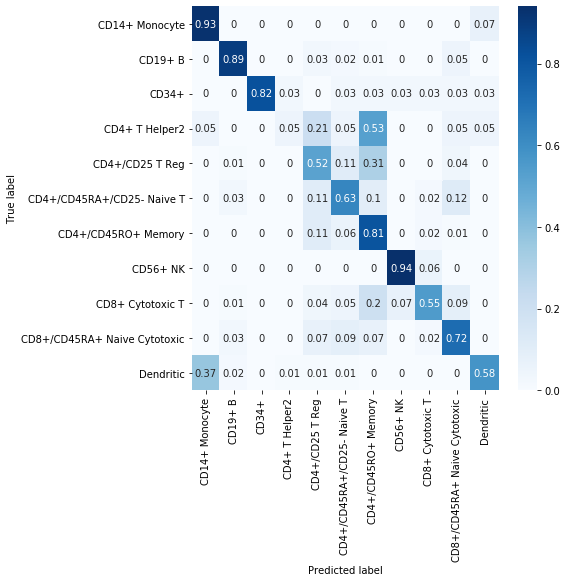

In [171]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, pollock_dataset.cell_types)

In [174]:
embedding = pollock_analysis.umap_final_layer(X_val, model.model)
embedding.shape

/home/estorrs/miniconda3/envs/pollock/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/pollock/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


(6815, 2)

In [175]:
ordered_adata = adata[pollock_dataset.cell_ids, :]
ordered_adata.obsm['X_umap'] = embedding
ordered_adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(ordered_adata, color=['predicted_cell_type', 'x'])

AttributeError: 'PollockDataset' object has no attribute 'cell_ids'